In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import zipfile

In [2]:
def get_data(file_name):
    with zipfile.ZipFile(file_name, 'r') as z:
        with z.open('train.csv') as f:
            data = pd.read_csv(f)
    return data

In [5]:
zip_file_path = 'actuarial-loss-estimation.zip'

with zipfile.ZipFile(zip_file_path, 'r') as z:
    with z.open('train.csv') as f:
        data = pd.read_csv(f)

In [79]:
def get_info(data):
    print(data.dtypes)
    print(data.head(3))

In [174]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

def encode_categorical(dataframe, categorical_columns):
    print(categorical_columns)
    encoder = OneHotEncoder(sparse=False)
    for col in categorical_columns:
            encoded = encoder.fit_transform(dataframe[[col]])
            encoded_df = pd.DataFrame(encoded, columns=[f"{col}_{category}" for category in encoder.categories_[0]])
            dataframe = pd.concat([dataframe, encoded_df], axis=1).drop(col, axis=1)
    print(dataframe)
    return dataframe

def compute_and_visualize_correlation(dataframe, target_column):
    correlation_matrix = dataframe.corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
    plt.show()
    return correlation_matrix[target_column].sort_values(ascending=False)

def identify_high_correlation(dataframe, threshold=0.8):
    correlation_matrix = dataframe.corr()
    high_correlation = set()

    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                colname = correlation_matrix.columns[i]
                high_correlation.add(colname)

    return high_correlation

def remove_outliers_using_percentiles(data, continious_columns, lower_percentile=0.25, upper_percentile=0.95, multiplier=1.5):
    numeric_data = data[continious_columns]
    Q1 = numeric_data.quantile(lower_percentile)
    Q3 = numeric_data.quantile(upper_percentile)
    IQR = Q3 - Q1
    filtered_data = data[~((numeric_data < (Q1 - multiplier * IQR)) | (numeric_data > (Q3 + multiplier * IQR))).any(axis=1)]
    return filtered_data

def get_columns_info(data):
    column_types = data.columns.to_series().groupby(data.dtypes).groups
    categorial = [column for column in data.columns if len(data[column].unique()) < 10]
    continious_columns = [column for key in column_types for column in column_types[key] if key!="object" and column not in categorial]
    print(categorial)
    print(continious_columns)
    return (categorial, continious_columns)

def remove_na(data):
    old_size = len(data)
    cleaned_data = data.dropna()
    new_size = len(cleaned_data)

    if old_size!=new_size:
        print(f'There were {old_size - new_size} records removed')
    else:
        print("No missing data")
    return cleaned_data

def process_columns(data):
    cleaned_data = remove_na(data)
    categorical_cols, continuous_cols = get_columns_info(cleaned_data)
    cleaned_data = remove_outliers_using_percentiles(cleaned_data, continuous_cols)
    cleaned_data = cleaned_data[categorical_cols+continuous_cols]
    total_cols = len(categorical_cols) + len(continuous_cols)
    cols_per_row = 3 
    rows = math.ceil(total_cols / cols_per_row)
    fig, axes = plt.subplots(rows, cols_per_row, figsize=(15, 5 * rows))
    axes = axes.flatten()
    for idx, col in enumerate(categorical_cols):
        proportion = cleaned_data[col].value_counts(normalize=True)
        sns.barplot(x=proportion.index, y=proportion.values, ax=axes[idx])
        axes[idx].set_title(f'Proportions for {col}')
        axes[idx].set_ylabel('Proportion')
        axes[idx].set_xlabel(col)
    for idx, col in enumerate(continuous_cols, start=len(categorical_cols)):
        sns.kdeplot(cleaned_data[col], fill=True, ax=axes[idx])
        axes[idx].set_title(f'Density for {col}')
        axes[idx].set_ylabel('Density')
        axes[idx].set_xlabel(col)
    for ax in axes[len(categorical_cols) + len(continuous_cols):]:
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    return cleaned_data

There were 29 records removed
['Gender', 'MaritalStatus', 'DependentChildren', 'DependentsOther', 'PartTimeFullTime', 'DaysWorkedPerWeek']
['Age', 'InitialIncurredCalimsCost', 'WeeklyWages', 'HoursWorkedPerWeek', 'UltimateIncurredClaimCost']


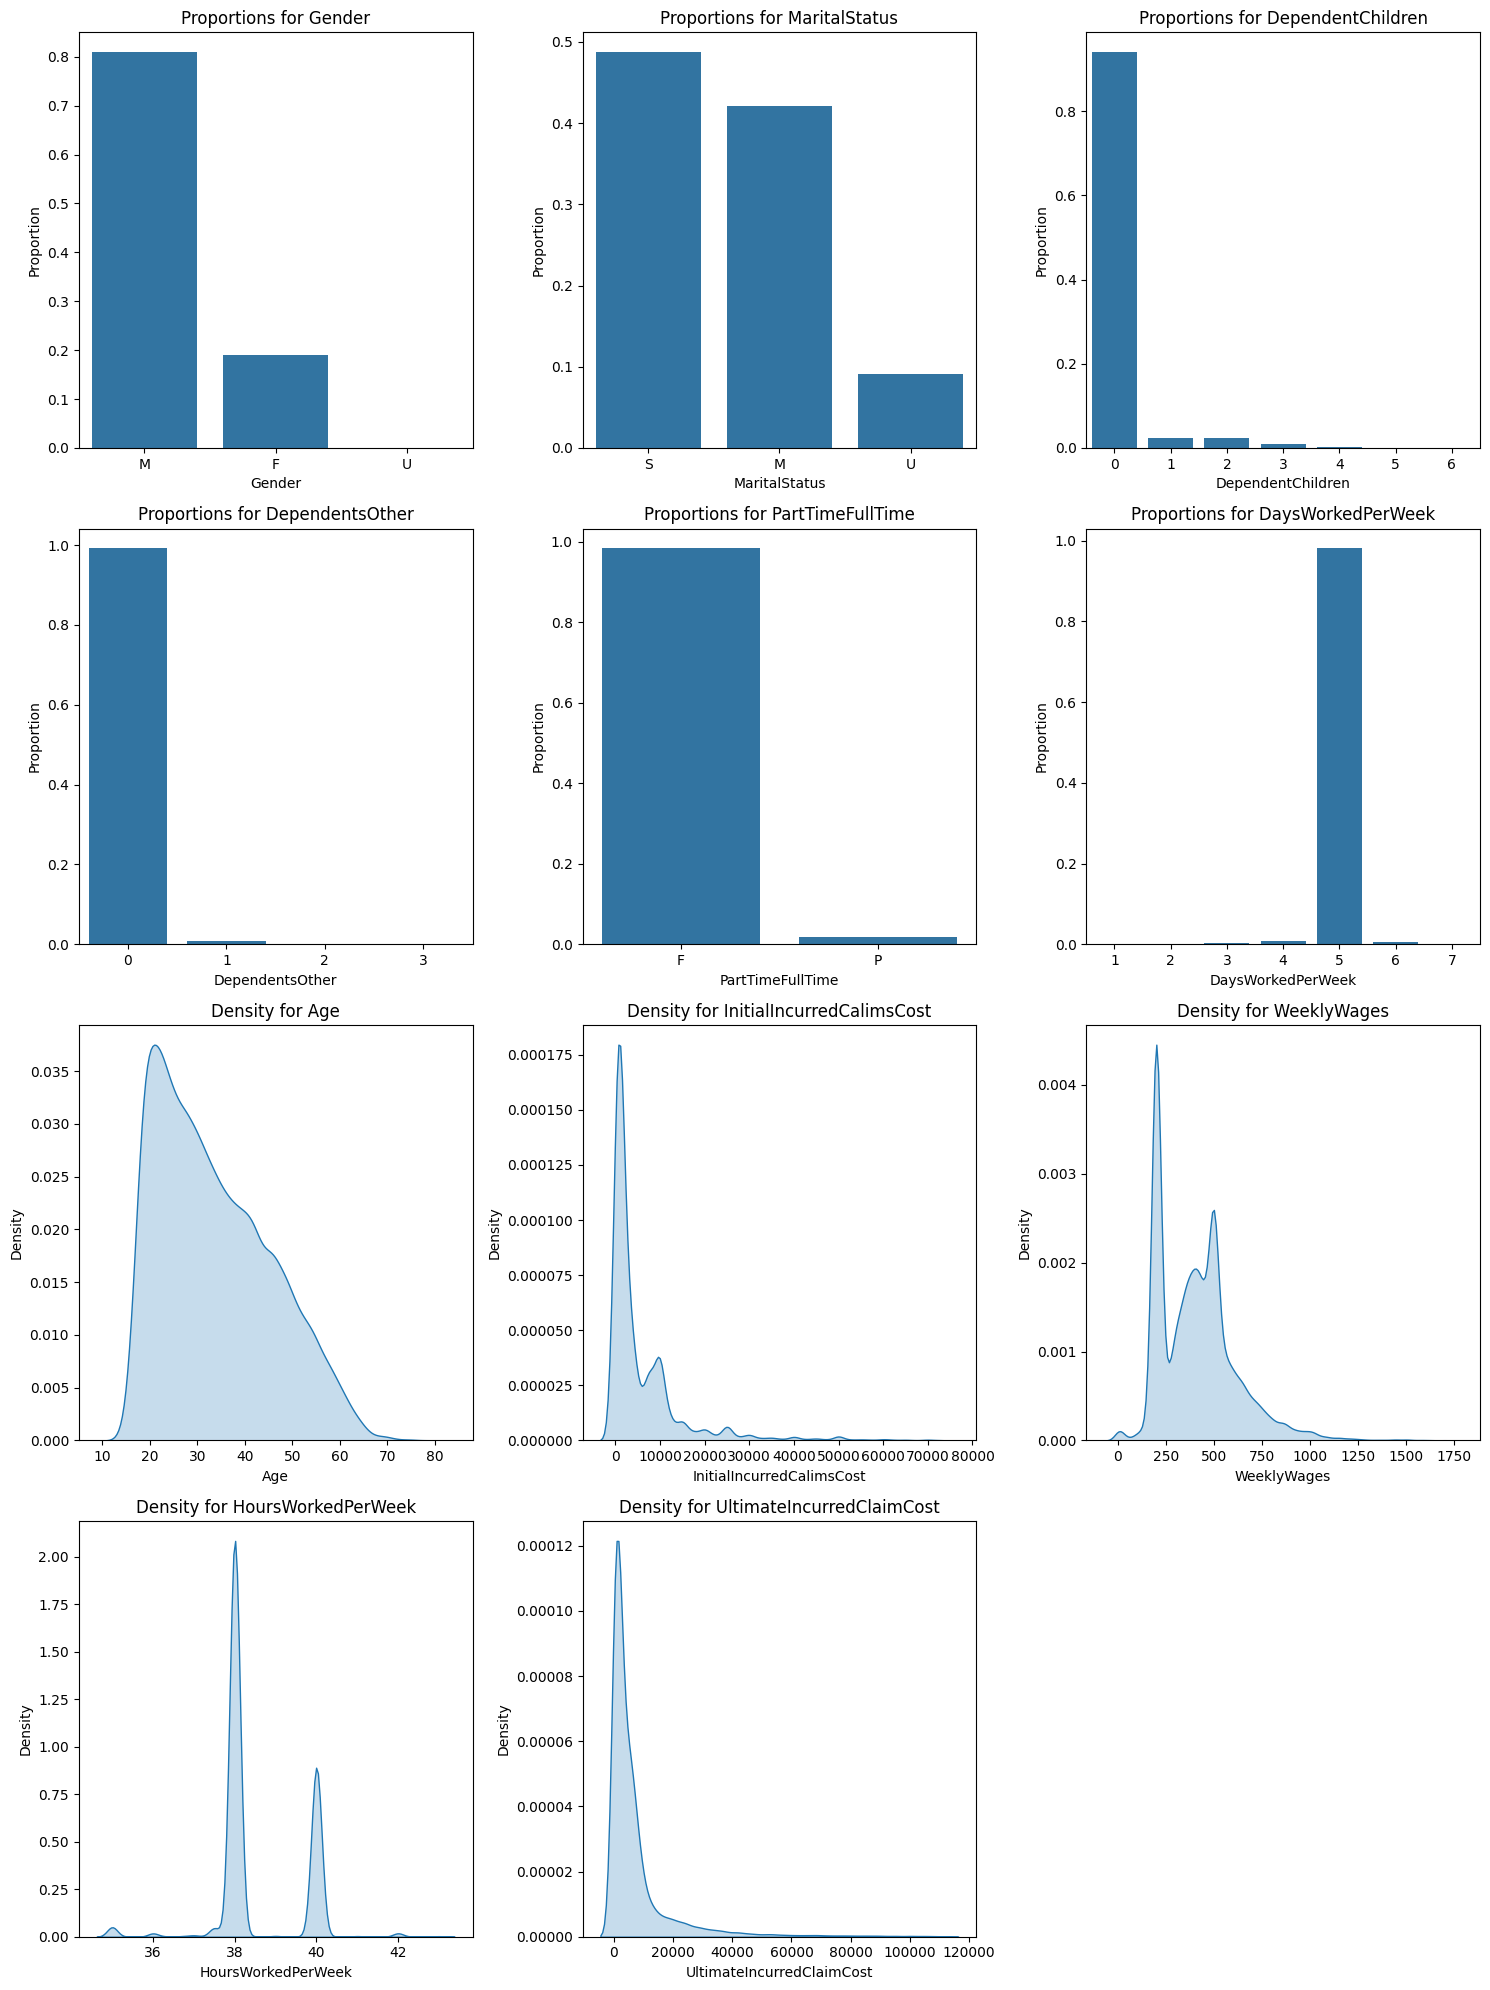

In [176]:
cleaned_data = process_columns(data)

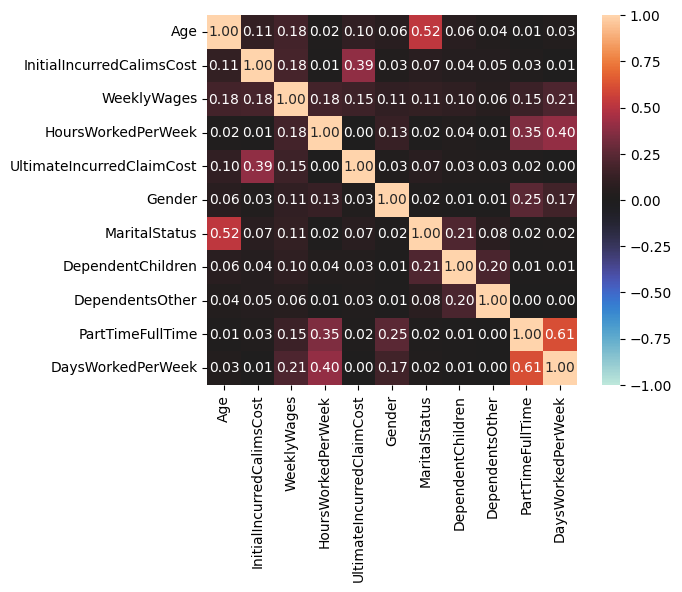

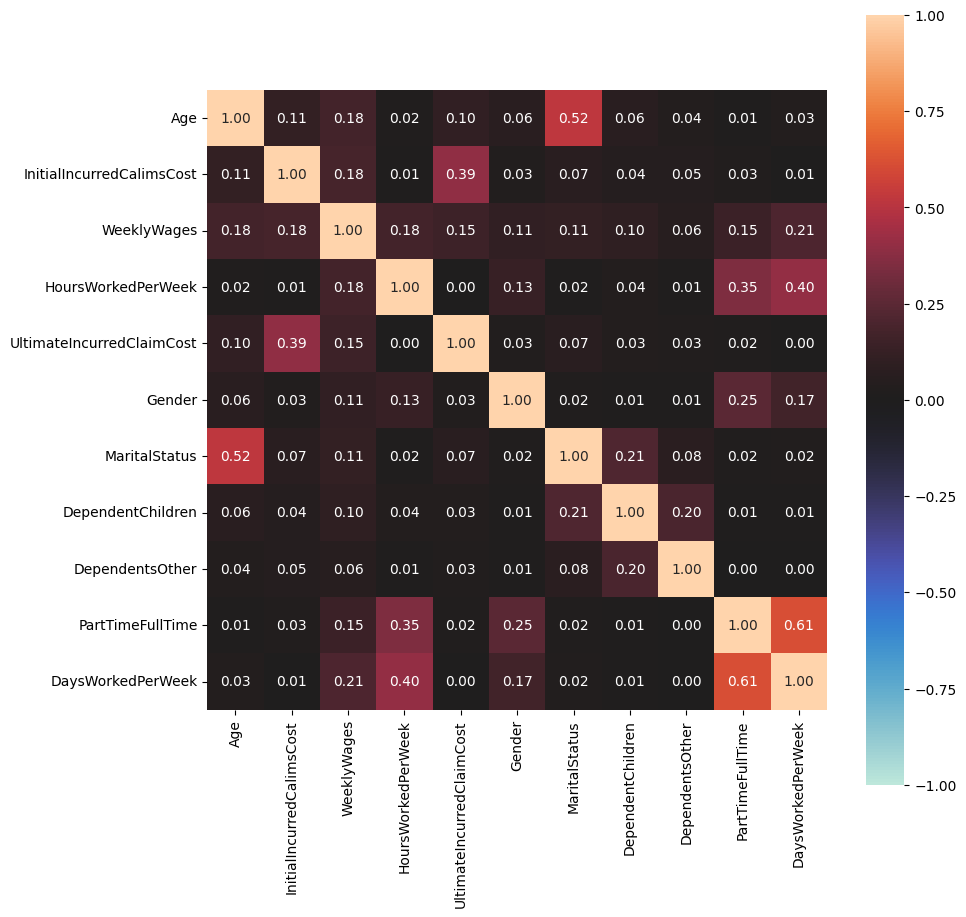

In [173]:
from dython.nominal import identify_nominal_columns
from dython.nominal import associations
corr_check = data[['Age', 'InitialIncurredCalimsCost', 'WeeklyWages', 'HoursWorkedPerWeek', 'UltimateIncurredClaimCost']+['Gender', 'MaritalStatus', 'DependentChildren', 'DependentsOther', 'PartTimeFullTime', 'DaysWorkedPerWeek']]
associations(corr_check, nominal_columns='auto', numerical_columns=None, mark_columns=False, nom_nom_assoc='cramer', num_num_assoc='pearson',  nan_replace_value="_DEFAULT_REPLACE_VALUE", ax=None, figsize=None, annot=True, fmt='.2f', cmap=None, sv_color='silver', cbar=True, vmax=1.0, vmin=None, plot=True, compute_only=False, clustering=False, title=None, filename=None)
complete_correlation= associations(corr_check, figsize=(10,10))


In [192]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import warnings
 
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
 

y = cleaned_data["UltimateIncurredClaimCost"]
regressor = RandomForestRegressor(n_estimators=3, random_state=0, oob_score=True)

regressor.fit(cleaned_data[['Age', 'InitialIncurredCalimsCost', 'WeeklyWages', 'HoursWorkedPerWeek', 'UltimateIncurredClaimCost']], y)

C:\Users\Illia Kvashuk\AppData\Roaming\Python\Python38\site-packages\sklearn\ensemble\_forest.py:578: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


RandomForestRegressor(n_estimators=3, oob_score=True, random_state=0)

In [194]:
# Access the OOB Score
oob_score = regressor.oob_score_
print(f'Out-of-Bag Score: {oob_score}')
 
# Making predictions on the same data or new data
predictions = regressor.predict(cleaned_data[['Age', 'InitialIncurredCalimsCost', 'WeeklyWages', 'HoursWorkedPerWeek', 'UltimateIncurredClaimCost']])
 
# Evaluating the model
mse = mean_squared_error(y, predictions)
print(f'Mean Squared Error: {mse}')
 
r2 = r2_score(y, predictions)
print(f'R-squared: {r2}')

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
 
# Assuming regressor is your trained Random Forest model
# Pick one tree from the forest, e.g., the first tree (index 0)
tree_to_plot = regressor.estimators_[0]
 
# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(tree_to_plot, feature_names=cleaned_data.columns.tolist())
plt.title("Decision Tree from Random Forest")
plt.show()

Out-of-Bag Score: 0.679731686266202
Mean Squared Error: 80.94441280177779
R-squared: 0.9999995425711395


KeyboardInterrupt: 

In [ ]:
target_variable = "Ultimate Cost"
